In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
from torchvision.datasets.utils import download_url
import tarfile
import torchvision.datasets as datasets
import os
from tqdm import tqdm
import seaborn
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  
    transforms.ToTensor(),  
])


In [3]:
dataset = datasets.ImageFolder(root='dataset', transform=transform)


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


class_names = dataset.classes
class_names


['Beagle',
 'Boxer',
 'Bulldog',
 'Dachshund',
 'German_Shepherd',
 'Golden_Retriever',
 'Labrador_Retriever',
 'Poodle',
 'Rottweiler',
 'Yorkshire_Terrier']

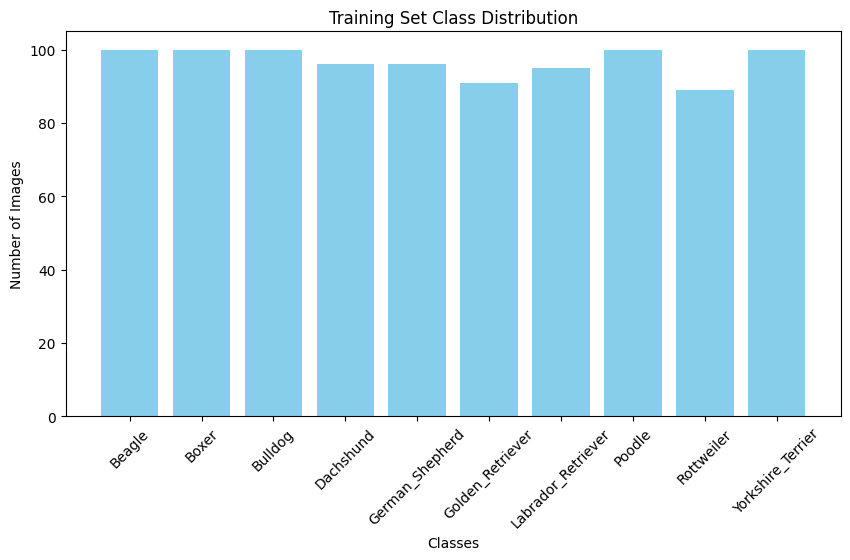

Class counts: {'Beagle': 100, 'Boxer': 100, 'Bulldog': 100, 'Dachshund': 96, 'German_Shepherd': 96, 'Golden_Retriever': 91, 'Labrador_Retriever': 95, 'Poodle': 100, 'Rottweiler': 89, 'Yorkshire_Terrier': 100}


In [4]:
import os 

def count_images_per_class(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_class_counts = count_images_per_class('dataset')

def plot_class_distribution(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_class_counts, 'Training Set Class Distribution')
print("Class counts:", train_class_counts)

In [5]:
num_classes = len(dataset.classes)
img, label = dataset[0]
img_shape = img.shape
img_size = img_shape[-1]
(num_classes, img_size)

(10, 32)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import random
def show_example():
    int = random.randint(0, len(dataset)-1)
    img, label = dataset[int]
    plt.imshow(img.permute(1,2,0))
    print("Label: " , dataset.classes[label] + " ["+str(label)+"]")

Label:  German_Shepherd [4]


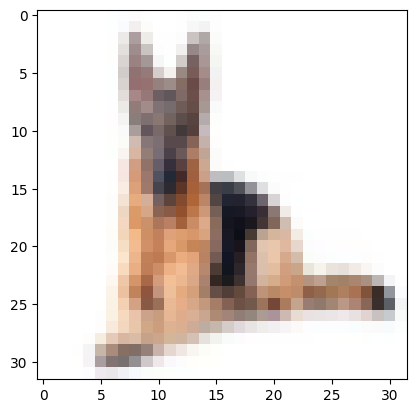

In [8]:
show_example()

In [9]:
batch_size = 128


train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=128, shuffle=False)

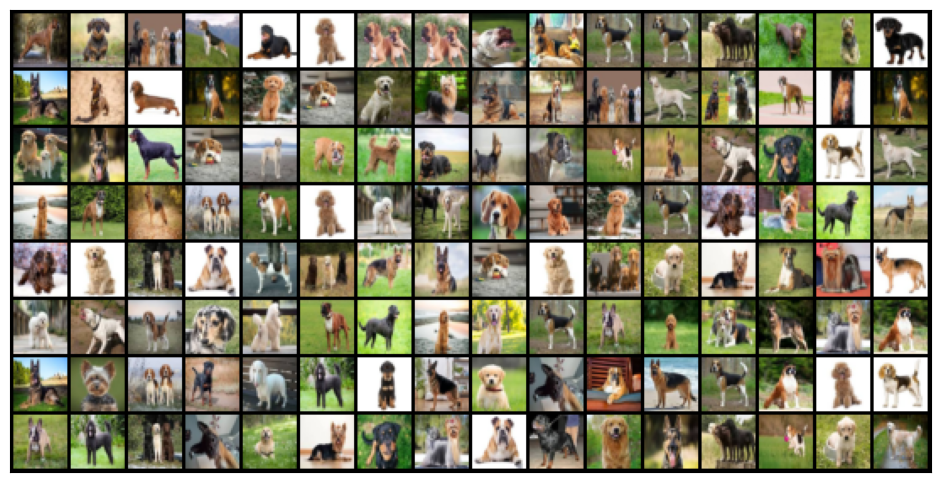

In [10]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_dl)


In [12]:
class CNN(nn.Module):
    def __init__(self,num_classes,img_size):
        super(CNN,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,kernel_size = 3, padding = 1),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2), #img_size by 2
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2), #img_size by 4
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.LeakyReLU(negative_slope=0.01, inplace=False),
            nn.MaxPool2d(kernel_size=2,stride=2), #img_size by 8
         )
        self.classifier = nn.Sequential(
            nn.Linear(256*(img_size//8)*(img_size//8),512),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Linear(512,num_classes)
        )
        
    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

In [13]:
model = CNN(num_classes,img_size)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [17]:
import matplotlib.pyplot as plt

def train(train_loader, model, criterion, optimizer, num_epochs):
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        total_loss = 0.0
        train_loader = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            total_loss += loss.item()
        
        epoch_loss = total_loss / len(train_loader)
        epoch_acc = total_correct / total_samples * 100
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%')

    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
    plt.title('Training accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.show()

Epoch [1/25], Train Loss: 2.3128, Train Accuracy: 9.06%


Epoch [2/25], Train Loss: 2.2661, Train Accuracy: 15.27%


Epoch [3/25], Train Loss: 2.1617, Train Accuracy: 21.73%


Epoch [4/25], Train Loss: 1.9235, Train Accuracy: 24.71%


Epoch [5/25], Train Loss: 1.7652, Train Accuracy: 35.71%


Epoch [6/25], Train Loss: 1.7687, Train Accuracy: 37.90%


Epoch [7/25], Train Loss: 1.4341, Train Accuracy: 48.12%


Epoch [8/25], Train Loss: 1.4232, Train Accuracy: 52.52%


Epoch [9/25], Train Loss: 1.2485, Train Accuracy: 55.24%


Epoch [10/25], Train Loss: 0.9438, Train Accuracy: 64.04%


Epoch [11/25], Train Loss: 0.7832, Train Accuracy: 73.74%


Epoch [12/25], Train Loss: 0.5575, Train Accuracy: 82.41%


Epoch [13/25], Train Loss: 0.3647, Train Accuracy: 87.45%


Epoch [14/25], Train Loss: 0.2436, Train Accuracy: 93.27%


Epoch [15/25], Train Loss: 0.2040, Train Accuracy: 96.25%


Epoch [16/25], Train Loss: 0.1616, Train Accuracy: 96.25%


Epoch [17/25], Train Loss: 0.1472, Train Accuracy: 96.25%


Epoch [18/25], Train Loss: 0.1320, Train Accuracy: 97.15%


Epoch [19/25], Train Loss: 0.0727, Train Accuracy: 98.97%


Epoch [20/25], Train Loss: 0.0420, Train Accuracy: 99.35%


Epoch [21/25], Train Loss: 0.0395, Train Accuracy: 99.48%


Epoch [22/25], Train Loss: 0.0295, Train Accuracy: 99.74%


Epoch [23/25], Train Loss: 0.0191, Train Accuracy: 99.61%


Epoch [24/25], Train Loss: 0.0088, Train Accuracy: 99.87%


Epoch [25/25], Train Loss: 0.0058, Train Accuracy: 99.87%


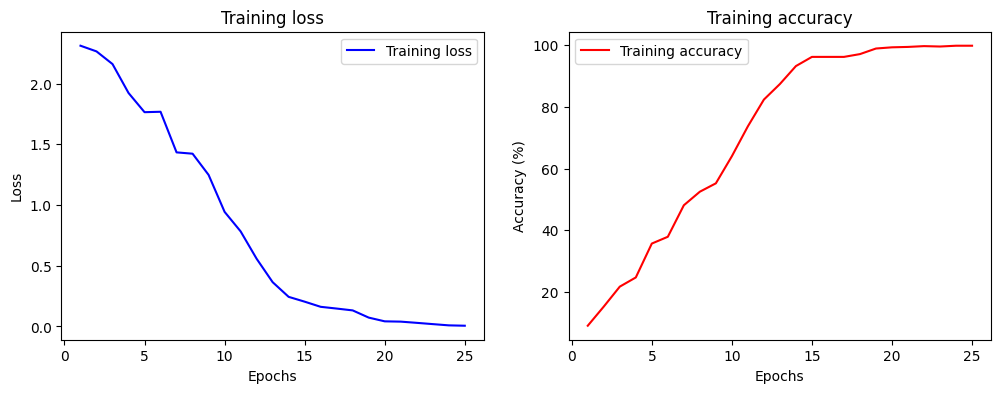

In [18]:
train(train_dl, model, criterion, optimizer, num_epochs=25)


In [19]:
torch.save(model.state_dict(), 'Dog_Classifier.pth')


In [20]:
PATH = 'Dog_Classifier.pth'
state = {'model': model.state_dict()}
torch.save(state, PATH)
model.load_state_dict(torch.load(PATH)['model'])
for k, v in model.named_parameters():
    print(k, v)

features.0.weight Parameter containing:
tensor([[[[ 0.1444,  0.0326, -0.0728],
          [ 0.1320,  0.0609, -0.1868],
          [-0.0441, -0.0551, -0.1078]],

         [[ 0.1160, -0.1252,  0.1314],
          [-0.0710,  0.0754, -0.0149],
          [ 0.1250,  0.0405,  0.0327]],

         [[-0.0010,  0.1348,  0.1644],
          [-0.0752,  0.0562, -0.0079],
          [ 0.1459,  0.0552, -0.0706]]],


        [[[-0.1421,  0.1224,  0.1037],
          [ 0.0514,  0.0607,  0.1695],
          [-0.1540,  0.0839, -0.0093]],

         [[ 0.0528,  0.0267,  0.1959],
          [-0.1669, -0.0714, -0.0765],
          [ 0.0634,  0.0585,  0.0484]],

         [[-0.0176,  0.0345,  0.0836],
          [-0.1690,  0.1273,  0.1840],
          [ 0.1322, -0.0474,  0.1162]]],


        [[[ 0.0699,  0.1431, -0.1777],
          [-0.1210,  0.0328, -0.1839],
          [ 0.0228, -0.0778, -0.0739]],

         [[-0.0552,  0.1734, -0.0458],
          [ 0.1602, -0.0160, -0.0862],
          [ 0.0085, -0.0444, -0.0802]],

    

Accuracy: 1.00


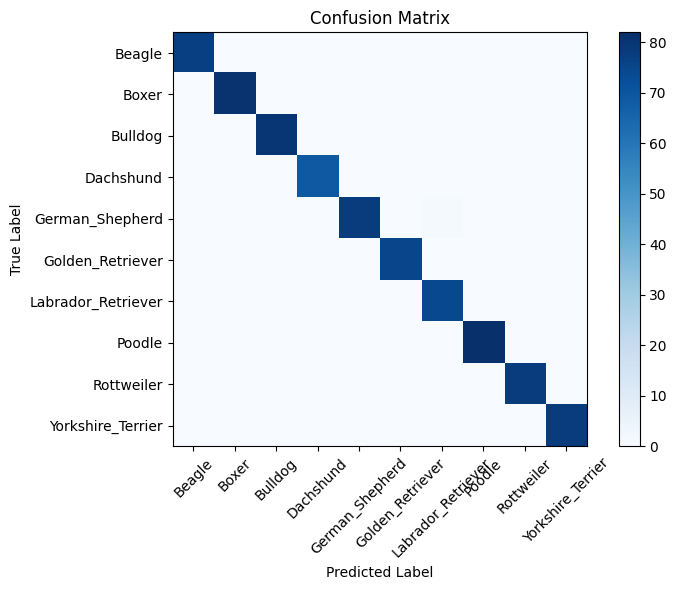

                    precision    recall  f1-score   support

            Beagle       1.00      1.00      1.00        77
             Boxer       1.00      1.00      1.00        81
           Bulldog       1.00      1.00      1.00        80
         Dachshund       1.00      1.00      1.00        69
   German_Shepherd       1.00      0.99      0.99        79
  Golden_Retriever       1.00      1.00      1.00        75
Labrador_Retriever       0.99      1.00      0.99        74
            Poodle       1.00      1.00      1.00        82
        Rottweiler       1.00      1.00      1.00        78
 Yorkshire_Terrier       1.00      1.00      1.00        78

          accuracy                           1.00       773
         macro avg       1.00      1.00      1.00       773
      weighted avg       1.00      1.00      1.00       773



In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
accuracy = np.mean(predictions == true_labels)
print(f'Accuracy: {accuracy:.2f}')

class_names = dataset.classes
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print(classification_report(true_labels, predictions, target_names=class_names))


Testing Accuracy: 0.99


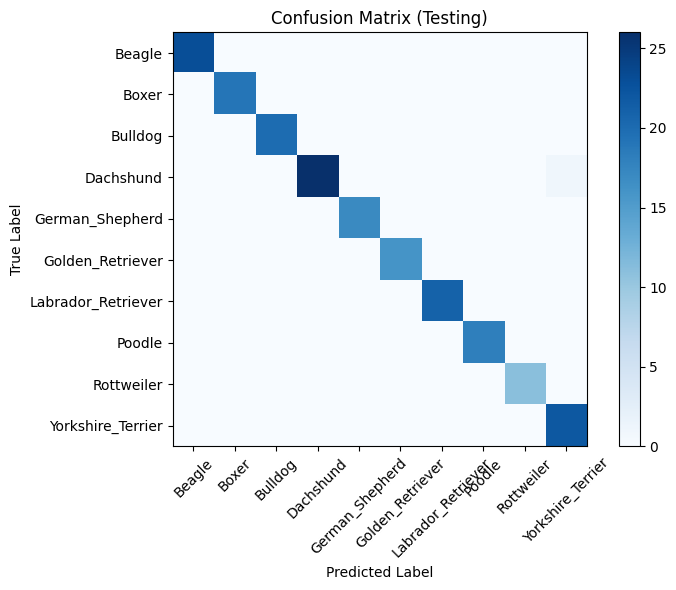

                    precision    recall  f1-score   support

            Beagle       1.00      1.00      1.00        23
             Boxer       1.00      1.00      1.00        19
           Bulldog       1.00      1.00      1.00        20
         Dachshund       1.00      0.96      0.98        27
   German_Shepherd       1.00      1.00      1.00        17
  Golden_Retriever       1.00      1.00      1.00        16
Labrador_Retriever       1.00      1.00      1.00        21
            Poodle       1.00      1.00      1.00        18
        Rottweiler       1.00      1.00      1.00        11
 Yorkshire_Terrier       0.96      1.00      0.98        22

          accuracy                           0.99       194
         macro avg       1.00      1.00      1.00       194
      weighted avg       1.00      0.99      0.99       194



In [22]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
accuracy = np.mean(predictions == true_labels)
print(f'Testing Accuracy: {accuracy:.2f}')

conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Testing)')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print(classification_report(true_labels, predictions, target_names=class_names))


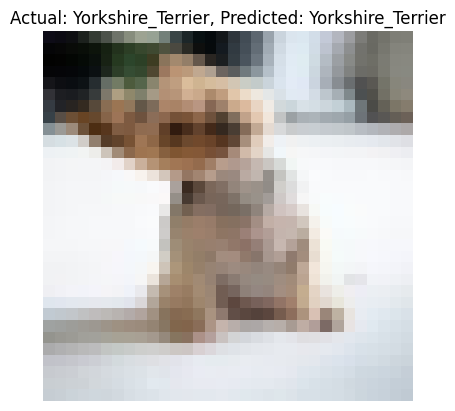

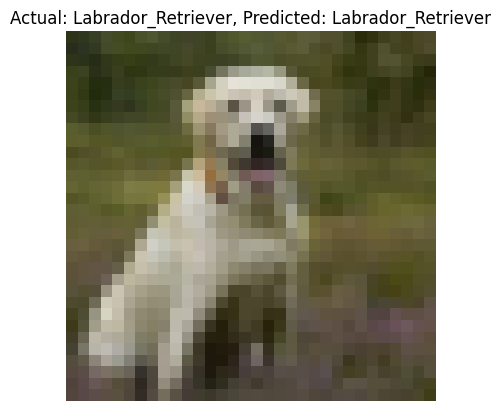

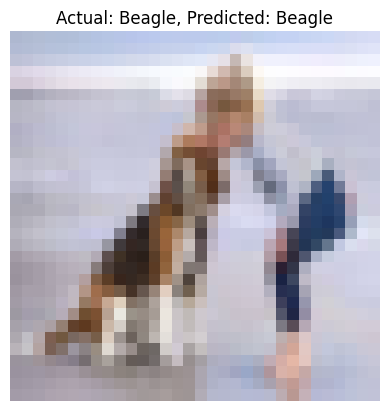

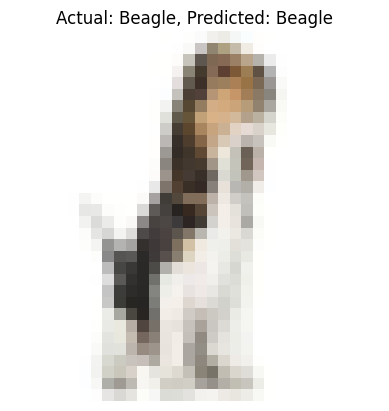

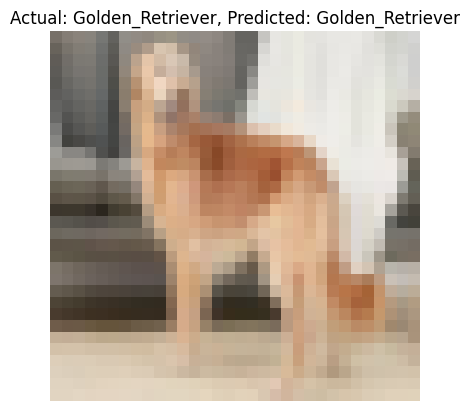

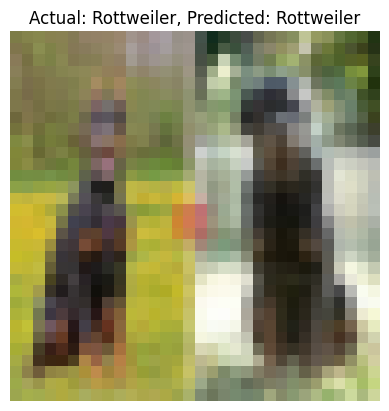

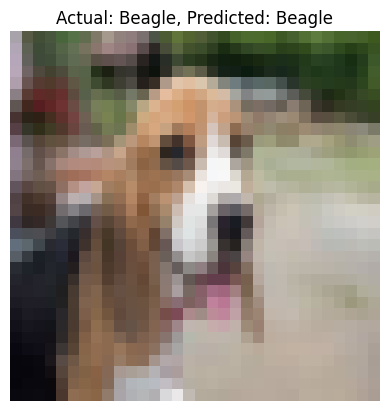

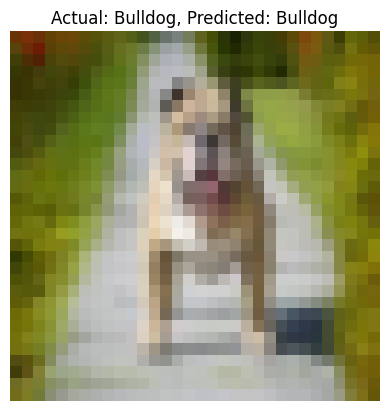

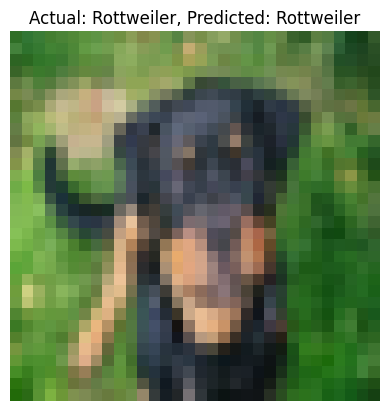

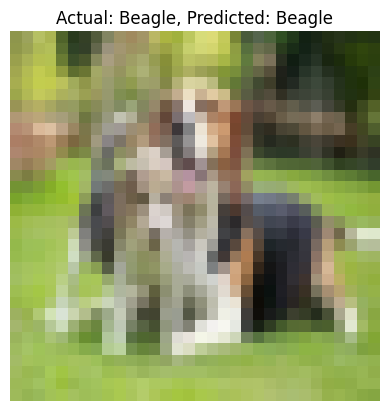

In [23]:
def imshow(img, title):
    npimg = img.cpu().numpy() 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

indices = np.random.randint(0, len(test_dataset), size=10)
random_images = [test_dataset[i] for i in indices]

images = torch.stack([img for img, _ in random_images])
labels = [label for _, label in random_images]

images = images.to(device)

with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

predicted = predicted.tolist()
labels = [dataset.classes[label] for label in labels]
predicted_labels = [dataset.classes[label] for label in predicted]

for i in range(10):
    imshow(images[i], f'Actual: {labels[i]}, Predicted: {predicted_labels[i]}')


In [24]:
from PIL import Image
import torch
import torchvision.transforms as transforms

def predict_image_class(image_path, model, class_names):
    image_path = "images/" + image_path
    entered_image = Image.open(image_path)

    
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ])

    transformed_image = transform(entered_image).unsqueeze(0)  

    
    model.eval()

    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transformed_image = transformed_image.to(device)

    
    with torch.no_grad():
        outputs = model(transformed_image)

    
    _, predicted = torch.max(outputs, 1)
    predicted_class = predicted.item()  

    
    probs = torch.softmax(outputs, dim=1)
    predicted_prob = probs[0, predicted_class].item()

    print(f'Predicted Class: {class_names[predicted_class]}, Probability: {predicted_prob:.2f}')
    
    plt.imshow(entered_image)
    plt.show()


Predicted Class: Bulldog, Probability: 1.00


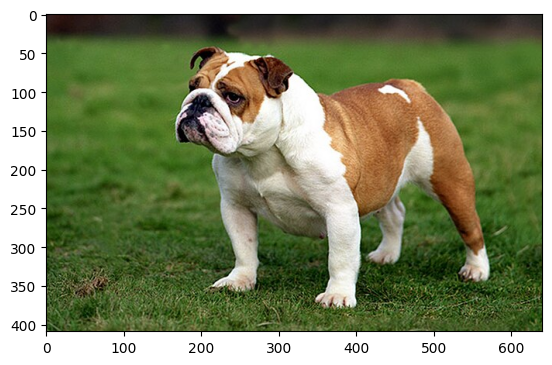

In [25]:
predict_image_class('img1.jpg', model, class_names)

Predicted Class: German_Shepherd, Probability: 1.00


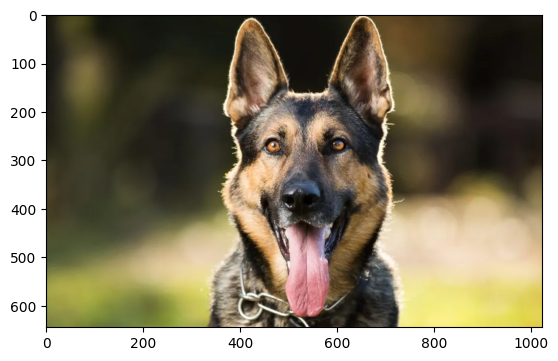

In [26]:
predict_image_class('img2.jpg', model, class_names)

Predicted Class: Dachshund, Probability: 1.00


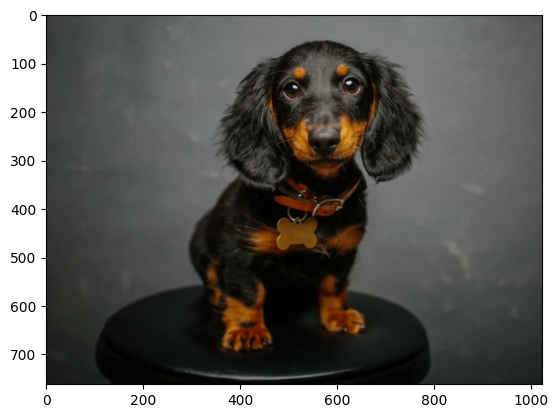

In [27]:
predict_image_class('img3.jpg', model, class_names)

Predicted Class: German_Shepherd, Probability: 0.64


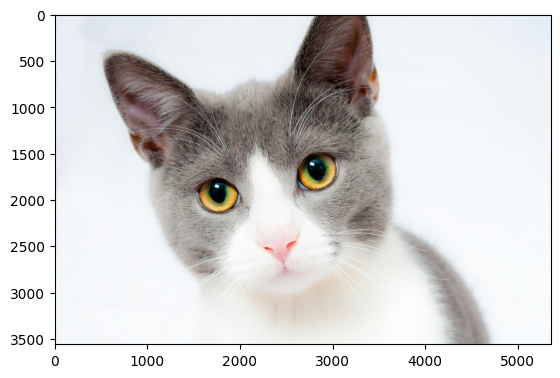

In [28]:
predict_image_class('cat.jpg', model, class_names)